# Load Dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/microsoft-catsvsdogs-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-catsvsdogs-dataset/readme[1].txt
/kaggle/input/microsoft-catsvsdogs-dataset/MSR-LA - 3467.docx
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7981.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6234.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1269.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3863.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6241.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10304.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/623.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2193.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11925.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3750.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11378.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2008.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10730.jpg
/kaggle/input/micros

In [2]:
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shutil
import matplotlib.pyplot as plt
import random
import tensorflow as tf

2025-06-21 14:41:01.098835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750516861.304112      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750516861.359982      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Cleaning Dataset to avoid corrupted files

In [3]:
source_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages" 
target_dir = "/kaggle/working/CleanPetImages"

for category in ["Cat", "Dog"]:
    os.makedirs(os.path.join(target_dir, category), exist_ok=True)
    for filename in os.scandir(os.path.join(source_dir, category)):
        if filename.is_file():
            try:
                with Image.open(filename.path) as img:
                    img.verify()
                shutil.copy2(filename.path, os.path.join(target_dir, category))
            except:
                pass


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


# Data spliting

In [4]:
clean_dir = "/kaggle/working/CleanPetImages" 

datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    preprocessing_function=None, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Training generator
train_gen = datagen.flow_from_directory(
    directory=clean_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = datagen.flow_from_directory(
    directory=clean_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


# CNN Model

In [5]:
model=models.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,(3,3),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512,activation="relu",kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1,activation="sigmoid")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750517029.418614      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,729 (73.49 MB)

 Trainable params: 19,264,769 (73.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

early_stop=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.keras", 
                             save_best_only=True, 
                             monitor="val_loss")


history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750517227.800714     116 service.cc:148] XLA service 0x785ef00142e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750517227.801692     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750517228.395092     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:56:29 11s/step - accuracy: 0.6250 - loss: 1.9500

I0000 00:00:1750517234.060569     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 278s 427ms/step - accuracy: 0.5910 - loss: 2.4324 - val_accuracy: 0.6561 - val_loss: 1.1795
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 423ms/step - accuracy: 0.7013 - loss: 1.0147 - val_accuracy: 0.7103 - val_loss: 0.7304
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - accuracy: 0.7373 - loss: 0.7578 - val_accuracy: 0.6773 - val_loss: 0.7460
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 420ms/step - accuracy: 0.7664 - loss: 0.6694 - val_accuracy: 0.6505 - val_loss: 1.0887
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 424ms/step - accuracy: 0.8055 - loss: 0.6876 - val_accuracy: 0.7901 - val_loss: 0.5932
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 418ms/step - accuracy: 0.8623 - loss: 0.4842 - val_accuracy: 0.8221 - val_loss: 0.5634
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 420ms/step - accuracy: 0.8756 - loss: 0.4363 - val_accuracy: 0.8737 - val_loss: 0.4639
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 417ms/step - accuracy: 0.8831 - loss: 0.39

# Model training visualization

In [9]:
def plot_training_curves(history):
    plt.figure(figsize=(13, 4), dpi=120)
    
    # Accuracy plot
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Training Accuracy')
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    # Loss plot
    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Training Loss')
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.show()


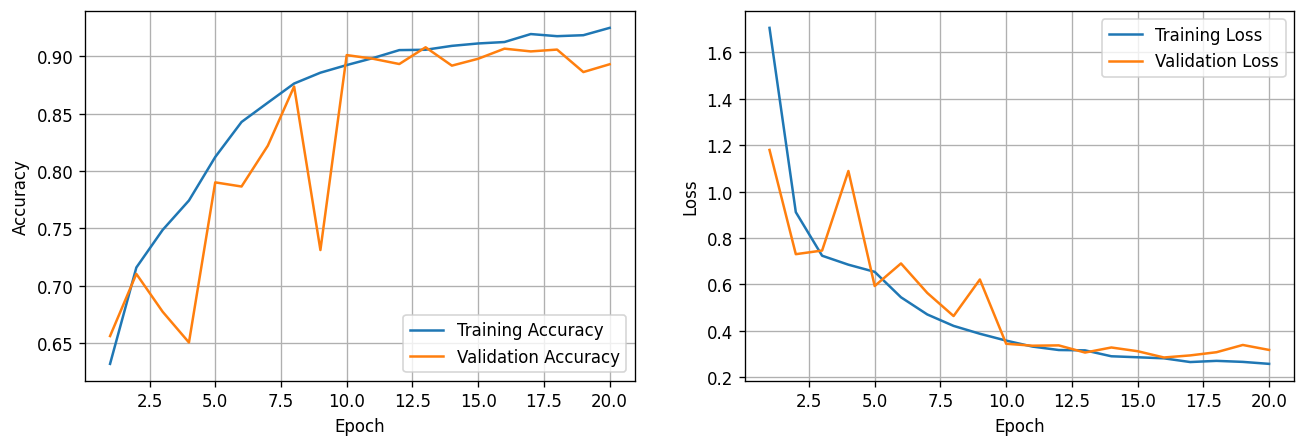

In [10]:
plot_training_curves(pd.DataFrame(history.history))

# Model save and Load

In [11]:
# Save the model
model.save('/kaggle/working/cat_vs_dogcnnModel.h5')

In [12]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/cat_vs_dogcnnModel.h5')

# Model Evaluation

In [13]:
#import tensorflow as tf

test_data = val_gen

X_test, y_test = None, None
for images, labels in test_data:
    if X_test is None or y_test is None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis=0)
        y_test = tf.concat([y_test, labels], axis=0)

    # Optional: stop when you reach all validation samples
    if X_test.shape[0] >= val_gen.samples:
        break

X_test.shape, y_test.shape


(TensorShape([4998, 224, 224, 3]), TensorShape([4998]))

In [14]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [15]:
test_score = model.evaluate(test_data, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 337ms/step - accuracy: 0.9045 - loss: 0.2903
Test Loss:  0.28468558192253113
Test Accuracy:  0.9101640582084656


# Classificaction

In [16]:
target_names = ['Cat', 'Dog']
print(classification_report(y_test , y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

         Cat    0.96748   0.84514   0.90218      2499
         Dog    0.86252   0.97159   0.91381      2499

    accuracy                        0.90836      4998
   macro avg    0.91500   0.90836   0.90800      4998
weighted avg    0.91500   0.90836   0.90800      4998



# Confusion Matrix

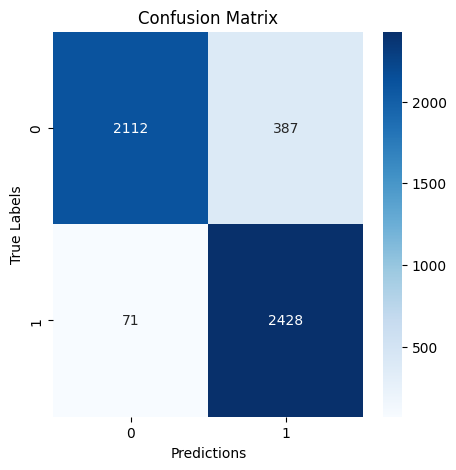

In [17]:
#from sklearn.metrics import confusion_matrix

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Model on test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_35/2289552515.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_names[int(y_pred_proba[index] > 0.5)]


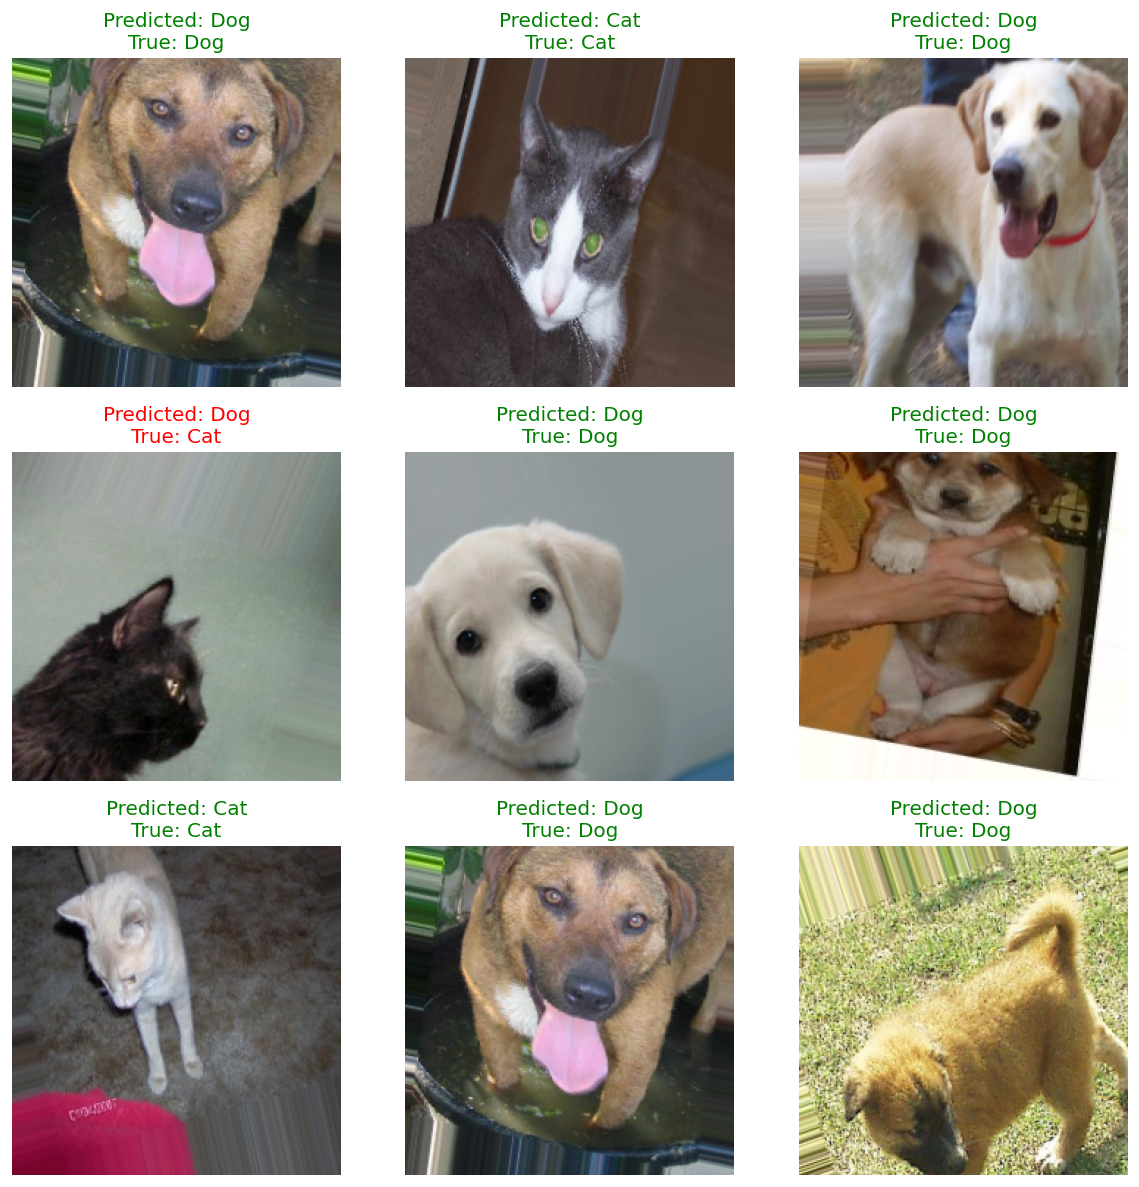

In [20]:
def plot_random_predictions(dataset, model, class_names):
    # Get one batch (images, labels)
    images, labels = next(iter(dataset))
    
    # Predict probabilities
    y_pred_proba = model.predict(images)
    
    plt.figure(figsize=(10, 10), dpi=120)
    
    for i in range(9):
        index = random.randint(0, len(images) - 1)
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[index]
        # If tensor, convert to numpy array
        if hasattr(img, 'numpy'):
            img = img.numpy()
        
        true_label = class_names[int(labels[index])]
        pred_label = class_names[int(y_pred_proba[index] > 0.5)]
        
        color = 'green' if pred_label == true_label else 'red'
        
        plt.imshow(img)
        plt.title(f'Predicted: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['Cat', 'Dog']
plot_random_predictions(val_gen, model, class_names)


In [ ]:
def plot_random_predictions(dataset, model, class_names):
    # Get one batch (images, labels)
    images, labels = next(iter(dataset))
    
    # Predict probabilities
    y_pred_proba = model.predict(images)
    
    plt.figure(figsize=(10, 10), dpi=120)
    
    for i in range(9):
        index = random.randint(0, len(images) - 1)
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[index]
        # If tensor, convert to numpy array
        if hasattr(img, 'numpy'):
            img = img.numpy()
        
        true_label = class_names[int(labels[index])]
        pred_label = class_names[int(y_pred_proba[index] > 0.5)]
        
        color = 'green' if pred_label == true_label else 'red'
        
        plt.imshow(img)
        plt.title(f'Predicted: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['Cat', 'Dog']
plot_random_predictions(val_gen, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipykernel_35/2289552515.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_names[int(y_pred_proba[index] > 0.5)]
